In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Load the credit data.
df = pd.read_csv("credit.csv")
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
# The response variable will be 'Balance.'
x = df.drop("Balance", axis=1)
y = df["Balance"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [4]:
# Trying to fit on all features in their current representation throws an error.
try:
    test_model = LinearRegression().fit(x_train, y_train)
except Exception as e:
    print("Error!:", e)

Error!: could not convert string to float: 'Female'


In [5]:
# Inspect the data types of the DataFrame's columns.
df.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
Balance        int64
dtype: object

In [6]:
### edTest(test_model1) ###
# Fit a linear model using only the numeric features in the dataframe.
numeric_features = ["Income", "Limit", "Rating", "Cards", "Age", "Education"]
model1 = LinearRegression().fit(x_train[numeric_features], y_train)

# Report train and test R2 scores.
train_score = model1.score(x_train[numeric_features], y_train)
test_score = model1.score(x_test[numeric_features], y_test)
print("Train R2:", train_score)
print("Test R2:", test_score)

Train R2: 0.8884475002185803
Test R2: 0.8212531865399557


In [7]:
# Look at unique values of Ethnicity feature.
print(
    "In the train data, Ethnicity takes on the values:",
    list(x_train["Ethnicity"].unique()),
)

In the train data, Ethnicity takes on the values: ['Asian', 'Caucasian', 'African American']


In [8]:
### edTest(test_design) ###
# Create x train and test design matrices creating dummy variables for the categorical.
x_train_design = pd.get_dummies(x_train, drop_first=True)
x_test_design = pd.get_dummies(x_test, drop_first=True)
x_train_design.head()

,Income,Limit,Rating,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
3,148.924,9504,681,3,36,11,1,0,0,1,0
18,49.570,6384,448,1,28,9,1,0,1,1,0
202,21.038,1448,145,2,58,13,1,0,1,0,1
250,10.363,2430,191,2,47,18,1,0,1,1,0
274,30.550,5869,439,5,81,9,1,0,0,0,0


In [9]:
# Confirm that all data types are now numeric.
x_train_design.dtypes

Income                 float64
Limit                    int64
Rating                   int64
Cards                    int64
Age                      int64
Education                int64
Gender_Female            uint8
Student_Yes              uint8
Married_Yes              uint8
Ethnicity_Asian          uint8
Ethnicity_Caucasian      uint8
dtype: object

In [10]:
### edTest(test_model2) ###
# Fit model2 on design matrix
model2 = LinearRegression().fit(x_train_design, y_train)

# Report train and test R2 scores
train_score = model2.score(x_train_design, y_train)
test_score = model2.score(x_test_design, y_test)
print("Train R2:", train_score)
print("Test R2:", test_score)

Train R2: 0.9552255011405162
Test R2: 0.9522674050276462


In [11]:
# Note that the intercept is not a part of .coef_ but is instead stored in .intercept_.
coefs = pd.DataFrame(model2.coef_, index=x_train_design.columns, columns=["beta_value"])
coefs

,beta_value
Income,-7.554059
Limit,0.198058
Rating,0.971292
Cards,19.123826
Age,-0.603695
Education,-1.078674
Gender_Female,-12.493725
Student_Yes,418.435398
Married_Yes,-6.150365
Ethnicity_Asian,13.295548


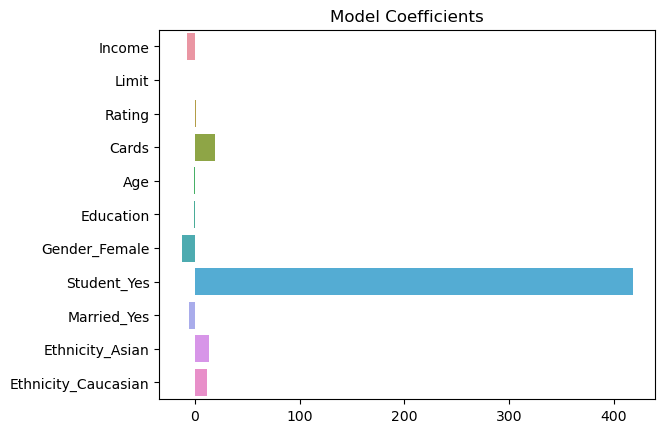

In [12]:
# Visualize crude measure of feature importance.
sns.barplot(data=coefs.T, orient="h").set(title="Model Coefficients");

In [13]:
### edTest(test_model3) ###
# Specify best categorical feature
best_cat_feature = "Student_Yes"

# Define the model.
features = ["Income", best_cat_feature]
model3 = LinearRegression()
model3.fit(x_train_design[features], y_train)

# Collect betas from fitted model.
beta0 = model3.intercept_
beta1 = model3.coef_[features.index("Income")]
beta2 = model3.coef_[features.index(best_cat_feature)]

# Display betas in a DataFrame.
coefs = pd.DataFrame(
    [beta0, beta1, beta2], index=["Intercept"] + features, columns=["beta_value"]
)
coefs

,beta_value
Intercept,177.658909
Income,6.773090
Student_Yes,371.895694


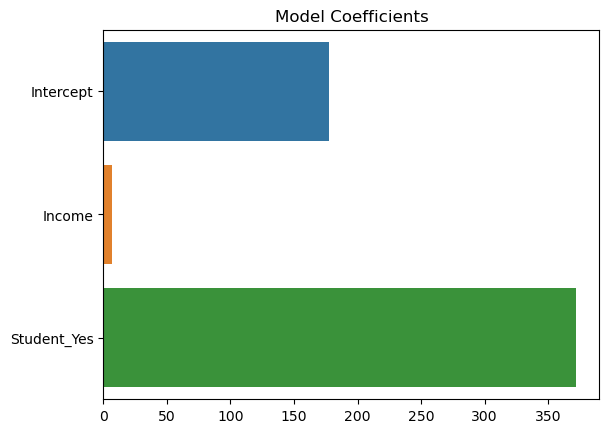

In [14]:
# Visualize crude measure of feature importance.
sns.barplot(data=coefs.T, orient="h").set(title="Model Coefficients");

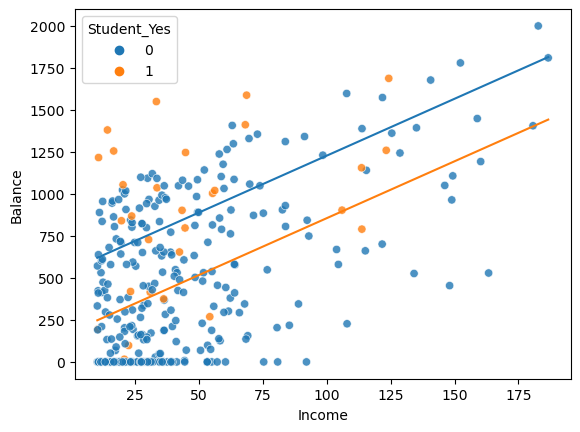

In [15]:
### edTest(test_prediction_lines) ###
# Create space of x values to predict on.
x_space = np.linspace(x["Income"].min(), x["Income"].max(), 1000)

# Generate 2 sets of predictions based on best categorical feature value.
# When categorical feature is true/present (1)
y_hat_yes = beta0 + beta1 * x_space + 1 * beta2
# When categorical feature is false/absent (0)
y_hat_no = beta0 + beta1 * x_space + 0 * beta2

# Plot the 2 prediction lines for students and non-students.
ax = sns.scatterplot(
    data=pd.concat([x_train_design, y_train], axis=1),
    x="Income",
    y="Balance",
    hue=best_cat_feature,
    alpha=0.8,
)
ax.plot(x_space, y_hat_yes)
ax.plot(x_space, y_hat_no);